In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import chaospy as cp
import matplotlib.pyplot as plt
import seaborn as sns

# import openturns as ot

# import numba as nb
# from pathlib import Path

In [3]:
from temfpy.uncertainty_quantification import eoq_model

# Harris Model from [Sensitivity analysis: A review of recent advances](https://www.sciencedirect.com/science/article/abs/pii/S0377221715005469)

In [4]:
# function for constructing fig. 4:


def eoq_model_partial(x, r=0.1, fix_num=0):
    """
    Calculate the value of eoq_harris,
    fixing one x.

    Args: 
        params (np.array): 1d numpy array,
                           cuurrently only need the first param,
                           which is interest & depreciation rate, r=10.
        x (np.array or list): 2d numpy array with the independent variables,
                              currently only need the first 3 columns.
        fix_num (int): take value of 0~n-1.

    Output:
        y (np.array): 2d numpy array with the dependent variables,
                      keeping the fix_num-th x fixed.
    """

    x_np = np.array(x)

    y = np.zeros(shape=(x_np.T.shape[0], x_np.T.shape[0]))

    if fix_num == 0:
        for i, x_i in enumerate(x_np[fix_num]):
            y[i] = np.sqrt((24 * r * x_i * x_np[2]) / x_np[1])
    elif fix_num == 1:
        for i, x_i in enumerate(x_np[fix_num]):
            y[i] = np.sqrt((24 * r * x_np[0] * x_np[2]) / x_i)
    elif fix_num == 2:
        for i, x_i in enumerate(x_np[fix_num]):
            y[i] = np.sqrt((24 * r * x_np[0] * x_i) / x_np[1])

    return y

## Data Generation

In [5]:
# Set flags

seed = 1234
n = 10000

x_min_multiplier = 0.9
x_max_multiplier = 1.1

m_0 = 1230
c_0 = 0.0135
s_0 = 2.15

In [6]:
x_min_multiplier * m_0, x_max_multiplier * m_0

(1107.0, 1353.0)

### No Monte Carlo

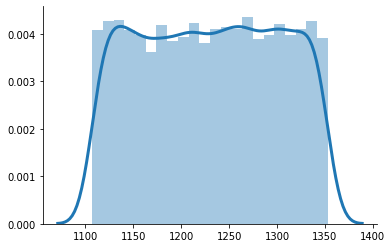

In [7]:
np.random.seed(seed)

m = np.random.uniform(low=x_min_multiplier * m_0, high=x_max_multiplier * m_0, size=n)
c = np.random.uniform(low=x_min_multiplier * c_0, high=x_max_multiplier * c_0, size=n)
s = np.random.uniform(low=x_min_multiplier * s_0, high=x_max_multiplier * s_0, size=n)

y = eoq_model([m, c, s])

plt.clf()
sns.distplot(m)

### Monte Carlo with `rvs`

Notice that compared to above, the range and count are much more spread.

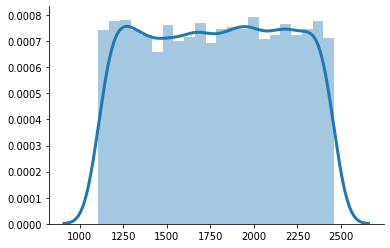

In [8]:
np.random.seed(seed)

m = stats.uniform(x_min_multiplier * m_0, x_max_multiplier * m_0).rvs(10000)
c = stats.uniform(x_min_multiplier * c_0, x_max_multiplier * c_0).rvs(10000)
s = stats.uniform(x_min_multiplier * s_0, x_max_multiplier * s_0).rvs(10000)

y = eoq_model([m, c, s])

plt.clf()
sns.distplot(m)

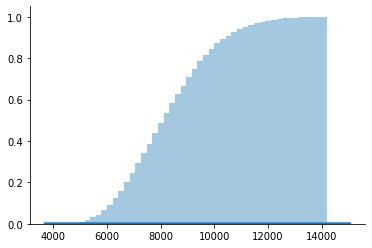

In [9]:
plt.clf()
sns.distplot(y, hist_kws=dict(cumulative=True))

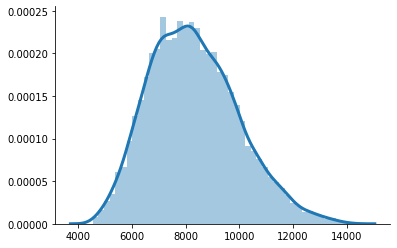

In [10]:
plt.clf()
sns.distplot(y)

### Monte Carlo with Chaospy (Closer to Borgonovoa & Plischkeb (2016))

In [11]:
sample_rule = "random"

In [12]:
np.random.seed(seed)

m = cp.Uniform(x_min_multiplier * m_0, x_max_multiplier * m_0).sample(
    n, rule=sample_rule,
)
c = cp.Uniform(x_min_multiplier * c_0, x_max_multiplier * c_0).sample(
    n, rule=sample_rule,
)
s = cp.Uniform(x_min_multiplier * s_0, x_max_multiplier * s_0).sample(
    n, rule=sample_rule,
)

y = eoq_model([m, c, s])

## Graphs

<Figure size 432x288 with 0 Axes>

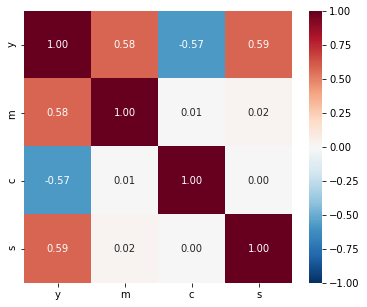

In [13]:
df_monte_carlo = pd.DataFrame(data=[y, m, c, s])

plt.clf()
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.heatmap(
    df_monte_carlo.T.corr(),
    vmin=-1,
    vmax=1,
    center=0,
    cmap="RdBu_r",
    annot=True,
    fmt=".2f",
)
ax.set_xticklabels(["y", "m", "c", "s"])
ax.set_yticklabels(["y", "m", "c", "s"])
plt.show()

### Fig. 4

In [14]:
y_fix_m = eoq_model_partial([m, c, s], fix_num=0)

In [15]:
y_fix_m.shape

(10000, 10000)

In [16]:
# don't try at home:

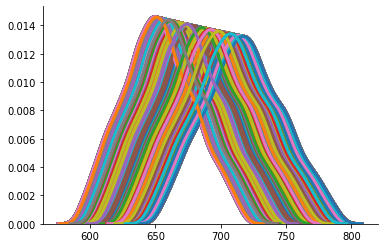

In [31]:
plt.clf()

for item in y_fix_m:
    sns.kdeplot(item)

# Harris: Correlated Sampling: Copula

## Generation

- `.Nataf(dist, R, ordering=None)`
- `.TCopula(dist, df, R)`
- `.AliMikhailHaq(dist, theta=0.5, eps=1e-06)`

In [16]:
m_chaospy_uniform = cp.Uniform(x_min_multiplier * m_0, x_max_multiplier * m_0)
c_chaospy_uniform = cp.Uniform(x_min_multiplier * c_0, x_max_multiplier * c_0)
s_chaospy_uniform = cp.Uniform(x_min_multiplier * s_0, x_max_multiplier * s_0)

x_chaospy_uniform = cp.J(m_chaospy_uniform, c_chaospy_uniform, s_chaospy_uniform)

In [17]:
R = [[1, 0.5, 0.4], [0.5, 1, 0.7], [0.4, 0.7, 1]]

In [18]:
x_chaospy_copula = cp.Nataf(x_chaospy_uniform, R)

np.random.seed(seed)
x_chaospy_copula_sample = x_chaospy_copula.sample(n, rule=sample_rule)

In [19]:
y_chaospy_copula = eoq_model(x_chaospy_copula_sample)

## Graphs

In [20]:
df_chaospy_copula = pd.DataFrame(
    data=[
        y_chaospy_copula,
        x_chaospy_copula_sample[0],
        x_chaospy_copula_sample[1],
        x_chaospy_copula_sample[2],
    ]
)

<Figure size 432x288 with 0 Axes>

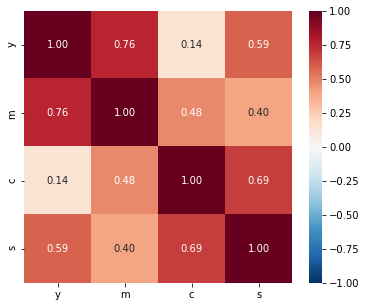

In [21]:
plt.clf()
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.heatmap(
    df_chaospy_copula.T.corr(),
    vmin=-1,
    vmax=1,
    center=0,
    cmap="RdBu_r",
    annot=True,
    fmt=".2f",
)
ax.set_xticklabels(["y", "m", "c", "s"])
ax.set_yticklabels(["y", "m", "c", "s"])
plt.show()

## X & y

<Figure size 432x288 with 0 Axes>

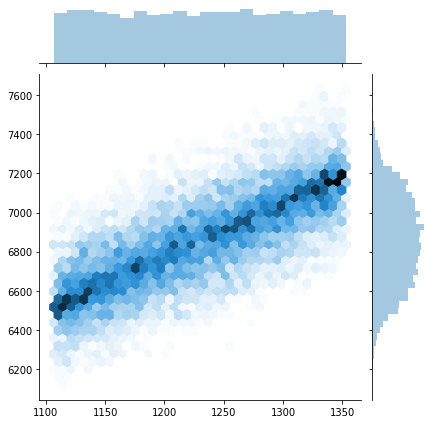

In [22]:
plt.clf()
sns.jointplot(x=x_chaospy_copula_sample[0], y=y_chaospy_copula, kind="hex")

<Figure size 432x288 with 0 Axes>

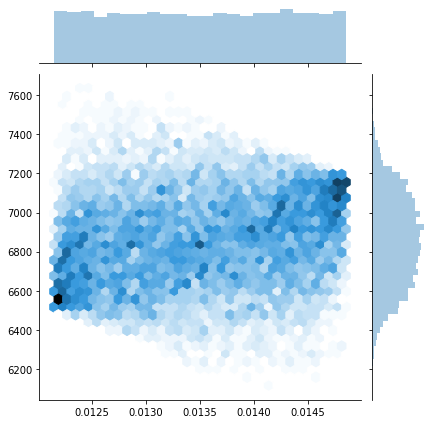

In [23]:
plt.clf()
sns.jointplot(x=x_chaospy_copula_sample[1], y=y_chaospy_copula, kind="hex")

<Figure size 432x288 with 0 Axes>

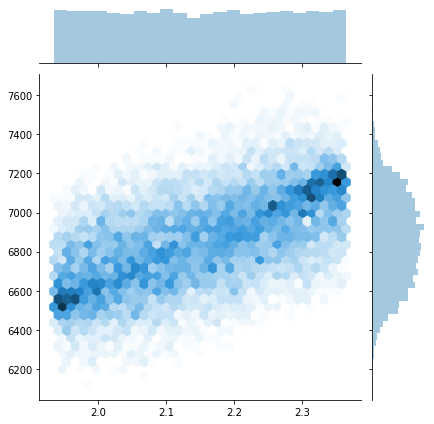

In [24]:
plt.clf()
sns.jointplot(x=x_chaospy_copula_sample[2], y=y_chaospy_copula, kind="hex")

# Harris: Correlated Sampling: Rosenblatt: stats

According to [Introducing Copula in Monte Carlo Simulation - Towards Data Science](https://towardsdatascience.com/introducing-copula-in-monte-carlo-simulation-9ed1fe9f905).

In [25]:
x_stats_normal = stats.multivariate_normal(mean=[m_0, s_0, c_0], cov=R)

np.random.seed(seed)
x_stats_normal_sample = x_stats_normal.rvs(n)

<Figure size 432x288 with 0 Axes>

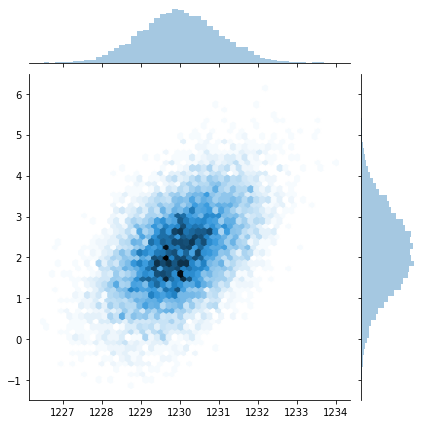

In [26]:
plt.clf()
sns.jointplot(x=x_stats_normal_sample[:, 0], y=x_stats_normal_sample[:, 1], kind="hex")

In [27]:
x_stats_uniform = stats.norm(loc=[m_0, s_0, c_0])

np.random.seed(seed)
x_stats_uniform_sample = x_stats_uniform.cdf(x_stats_normal_sample)

<Figure size 432x288 with 0 Axes>

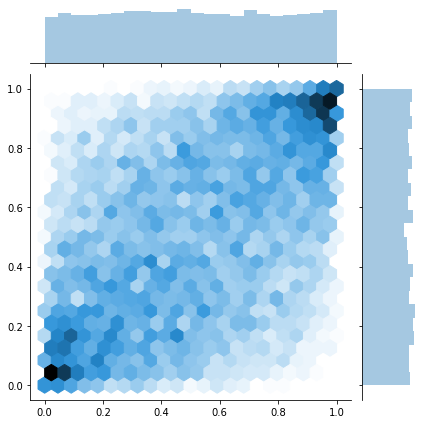

In [28]:
plt.clf()
sns.jointplot(
    x=x_stats_uniform_sample[:, 0], y=x_stats_uniform_sample[:, 1], kind="hex"
)

In [29]:
m_stats_uniform = stats.uniform.ppf(
    x_stats_uniform_sample[:, 0],
    loc=x_min_multiplier * m_0,
    scale=(x_max_multiplier - x_min_multiplier) * m_0,
)

In [30]:
s_stats_uniform = stats.uniform.ppf(
    x_stats_uniform_sample[:, 1],
    loc=x_min_multiplier * s_0,
    scale=(x_max_multiplier - x_min_multiplier) * s_0,
)

In [31]:
c_stats_uniform = stats.uniform.ppf(
    x_stats_uniform_sample[:, 2],
    loc=x_min_multiplier * c_0,
    scale=(x_max_multiplier - x_min_multiplier) * c_0,
)

In [32]:
y_stats_rosenblatt = eoq_model([m_stats_uniform, s_stats_uniform, c_stats_uniform])

## Graphs

<Figure size 432x288 with 0 Axes>

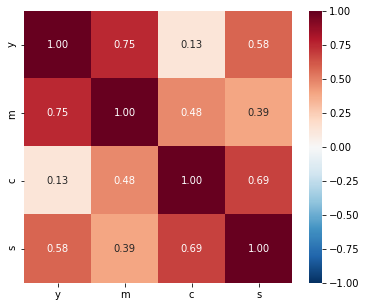

In [33]:
df_stats_rosenblatt = pd.DataFrame(
    data=[y_stats_rosenblatt, m_stats_uniform, s_stats_uniform, c_stats_uniform]
)

plt.clf()
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.heatmap(
    df_stats_rosenblatt.T.corr(),
    vmin=-1,
    vmax=1,
    center=0,
    cmap="RdBu_r",
    annot=True,
    fmt=".2f",
)
ax.set_xticklabels(["y", "m", "c", "s"])
ax.set_yticklabels(["y", "m", "c", "s"])
plt.show()

<Figure size 432x288 with 0 Axes>

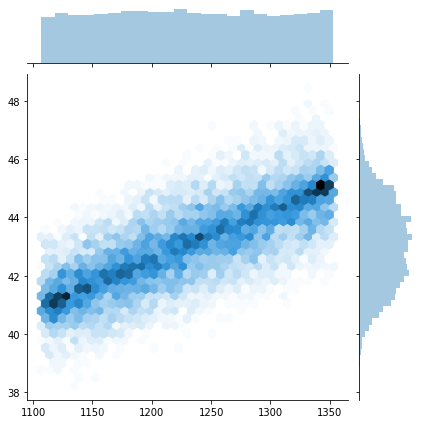

In [34]:
plt.clf()
sns.jointplot(x=m_stats_uniform, y=y_stats_rosenblatt, kind="hex")

<Figure size 432x288 with 0 Axes>

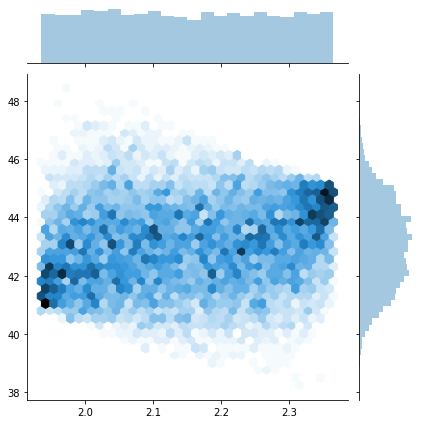

In [35]:
plt.clf()
sns.jointplot(x=s_stats_uniform, y=y_stats_rosenblatt, kind="hex")

<Figure size 432x288 with 0 Axes>

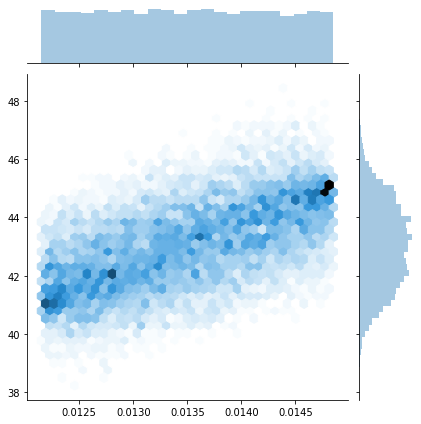

In [36]:
plt.clf()
sns.jointplot(x=c_stats_uniform, y=y_stats_rosenblatt, kind="hex")

# Harris: Correlated Sampling: Rosenblatt: chaospy

In [37]:
x_chaospy_normal = cp.MvNormal(loc=[m_0, s_0, c_0], scale=R)

cp.Cov(x_chaospy_normal)

array([[1. , 0.5, 0.4],
       [0.5, 1. , 0.7],
       [0.4, 0.7, 1. ]])

In [38]:
np.random.seed(seed)
x_chaospy_normal_sample = x_chaospy_normal.sample(n, rule=sample_rule)

<Figure size 432x288 with 0 Axes>

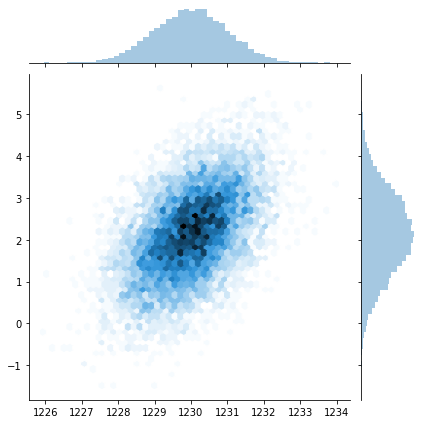

In [39]:
plt.clf()
sns.jointplot(x=x_chaospy_normal_sample[0], y=x_chaospy_normal_sample[1], kind="hex")

In [42]:
x_chaospy_rosenblatt_middle = x_chaospy_normal.fwd(x_chaospy_normal_sample)

<Figure size 432x288 with 0 Axes>

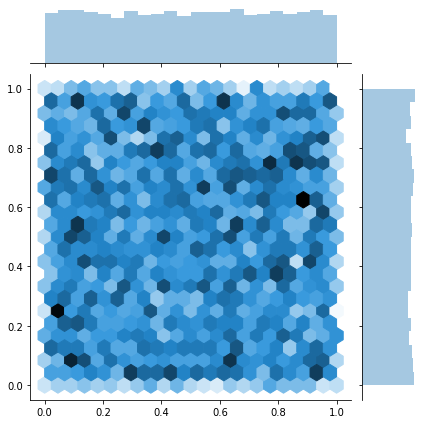

In [59]:
plt.clf()
sns.jointplot(
    x=x_chaospy_rosenblatt_middle[0], y=x_chaospy_rosenblatt_middle[1], kind="hex"
)

# Why? WHY????
# I suspect ``chaospy`` is not very good at handeling ≥3 dim distributions.

In [41]:
x_chaospy_uniform = cp.J(m_chaospy_uniform, c_chaospy_uniform, s_chaospy_uniform)

cp.Cov(x_chaospy_uniform)

array([[5.04300000e+03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.07500000e-07, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.54083333e-02]])

In [44]:
x_chaospy_uniform

J(Uniform(lower=1107.0, upper=1353.0), Uniform(lower=0.01215, upper=0.01485), Uniform(lower=1.935, upper=2.365))

In [79]:
x_chaospy_rosenblatt = x_chaospy_uniform.inv(x_chaospy_rosenblatt_middle)
x_chaospy_rosenblatt

array([[1.15411378e+03, 1.26003876e+03, 1.21468102e+03, ...,
        1.14305149e+03, 1.28058244e+03, 1.31385242e+03],
       [1.40850581e-02, 1.37001970e-02, 1.39601155e-02, ...,
        1.48090353e-02, 1.48210206e-02, 1.43411871e-02],
       [2.17333584e+00, 2.01282064e+00, 2.09673382e+00, ...,
        1.98683879e+00, 2.07812803e+00, 2.20184715e+00]])

<Figure size 432x288 with 0 Axes>

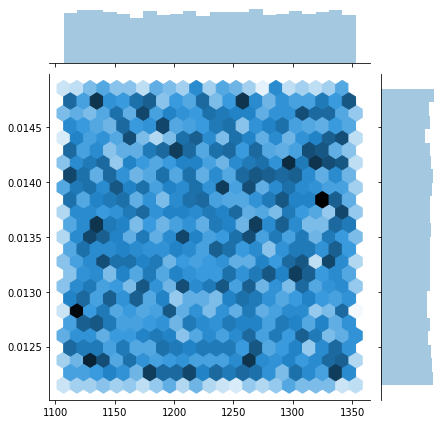

In [81]:
plt.clf()
sns.jointplot(x=x_chaospy_rosenblatt[0], y=x_chaospy_rosenblatt[1], kind="hex")

In [80]:
y_chaospy_rosenblatt = eoq_model(x_chaospy_rosenblatt)

## Graphs

<Figure size 432x288 with 0 Axes>

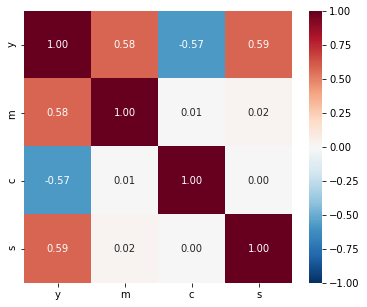

In [73]:
df_chaospy_rosenblatt = pd.DataFrame(
    data=[
        y_chaospy_rosenblatt,
        x_chaospy_rosenblatt[0],
        x_chaospy_rosenblatt[1],
        x_chaospy_rosenblatt[2],
    ]
)

plt.clf()
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.heatmap(
    df_chaospy_rosenblatt.T.corr(),
    vmin=-1,
    vmax=1,
    center=0,
    cmap="RdBu_r",
    annot=True,
    fmt=".2f",
)
ax.set_xticklabels(["y", "m", "c", "s"])
ax.set_yticklabels(["y", "m", "c", "s"])

plt.show()

# Test openTURNS

Import failed. See [Error when importing · Issue #1518 · openturns/openturns](https://github.com/openturns/openturns/issues/1518).

# Testing ChaosPy: [Distributions — ChaosPy documentation](https://chaospy.readthedocs.io/en/master/distributions/index.html)

In [90]:
# to create a Gaussian random variable:
distribution = cp.Normal(mu=2, sigma=2)

In [91]:
# to create values from the probability density function:
t = np.linspace(-3, 3, 9)
distribution.pdf(t).round(3)

array([0.009, 0.021, 0.043, 0.078, 0.121, 0.164, 0.193, 0.198, 0.176])

In [93]:
# create values from the cumulative distribution function:
distribution.cdf(t).round(3)

array([0.006, 0.017, 0.04 , 0.085, 0.159, 0.266, 0.401, 0.55 , 0.691])

In [94]:
# To be able to perform any Monte Carlo method,
# each distribution contains random number generator:
distribution.sample(6).round(4)

array([3.1908, 1.5794, 2.1213, 0.3613, 2.2973, 2.5376])

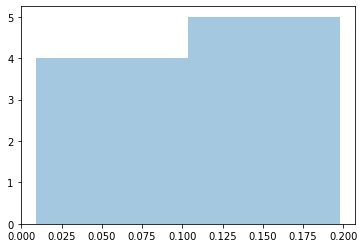

In [101]:
plt.clf()
sns.distplot(distribution.pdf(t).round(3), kde=False)

In [103]:
# to create low-discrepancy Hammersley sequences
# samples combined with antithetic variates:
distribution.sample(size=6, rule="halton", antithetic=True).round(4)

array([ 3.349 ,  0.651 , -0.3007,  4.3007,  2.6373,  1.3627])

## Moments: [Descriptive Statistics — ChaosPy documentation](https://chaospy.readthedocs.io/en/master/descriptives.html#descriptives)

In [104]:
# the variance is defined as follows:
distribution.mom(2) - distribution.mom(1) ** 2

4.0

In [108]:
# or:
cp.Var(distribution)

array(4.)

## Seeding

In [112]:
np.random.seed(1234)
distribution.sample(5).round(4)

array([0.2554, 2.622 , 1.6865, 3.5808, 3.5442])

In [115]:
distribution.sample(5).round(4)

array([ 2.308 ,  2.0155, -2.4076,  3.4964,  4.3766])

## [Copulas — ChaosPy documentation](https://chaospy.readthedocs.io/en/master/distributions/copulas.html)

In [134]:
np.random.seed(1234)
dist = cp.Iid(cp.Uniform(), 2)
copula = cp.Gumbel(dist, theta=1.5)

In [135]:
copula

Gumbel(Iid(Uniform(lower=0, upper=1), 2), theta=1.5)

In [136]:
np.random.seed(1234)
sample = copula.sample(10000)

<Figure size 432x288 with 0 Axes>

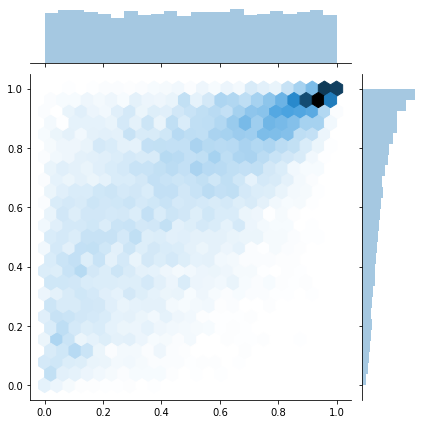

In [137]:
plt.clf()
sns.jointplot(x=sample[0], y=sample[1], kind="hex")